In [407]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from wordcloud import WordCloud

from sklearn.model_selection import train_test_split

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score, plot_confusion_matrix

from sklearn.decomposition import PCA

In [154]:
df = pd.read_json('data/Graduate - HEADLINES dataset (2019-06).json', lines=True)

In [155]:
df.shape

(26709, 2)

# Word Clouds

In [37]:
sarcastic_words = ' '.join(list(df[df['is_sarcastic'] == 1]['headline']))
sarcastic_wc = WordCloud(width=512, height=512,).generate(sarcastic_words)

non_sarcastic_words = ' '.join(list(df[df['is_sarcastic'] == 0]['headline']))
non_sarcastic_wc = WordCloud(width=512, height=512,).generate(non_sarcastic_words)

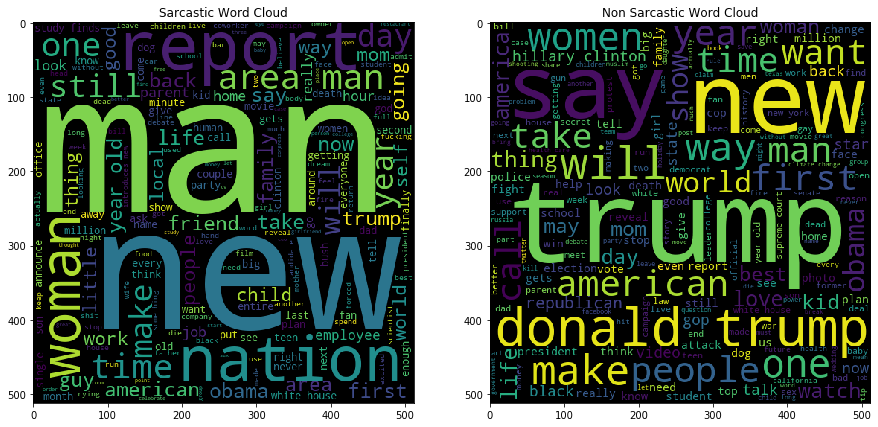

In [46]:
fig, axs = plt.subplots(1, 2, figsize=(15,15))

axs[0].imshow(sarcastic_wc)
axs[0].set_title('Sarcastic Word Cloud')

axs[1].imshow(non_sarcastic_wc)
axs[1].set_title('Non Sarcastic Word Cloud')

plt.show()

It's hard to tell which word cloud is which so except pretty visualization it does not give a lot in this case

# EDA

Its always good to know the proportion of classes

In [18]:
sarcastic_count = df[ df["is_sarcastic"] == 1].shape[0]
non_sarcastic_count = df.shape[0] - sarcastic_count
print(f'Sarcastic texts nr: {sarcastic_count} , what is {sarcastic_count/df.shape[0] * 100:.2f}% of data')
print(f'Nen Sarcastic texts nr: {non_sarcastic_count} , what is {non_sarcastic_count/df.shape[0] * 100:.2f}% of data')

Sarcastic texts nr: 11724 , what is 43.90% of data
Nen Sarcastic texts nr: 14985 , what is 56.10% of data


The classes are not equally distributed but the difference is not huge. Firsty i will test models without under or oversampling, but appart from calculating accuracy, i will also use precision and recall.

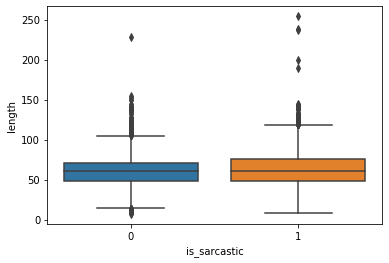

In [45]:
df['length'] = df['headline'].map(lambda x: len(x))
sns.boxplot(x='is_sarcastic', y='length', data=df);

The average length of headlines in both cases are similar.

# Spliting Data

First lets split the data to avoid leakage

In [93]:
def get_class_distr(df, name=""):
    count = df.groupby(['is_sarcastic'])['headline'].count()
    print(f'{name} set has {count[1]}({count[1] / count.sum() * 100:.2f}%) sarcastic, and {count[0]}({count[0] / count.sum() * 100:.2f}%) non-sarcastic headlines')

In [156]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42, stratify = df['is_sarcastic'])

In [157]:
get_class_distr(df_train, "Train")
get_class_distr(df_test, "Test")

Train set has 9379(43.89%) sarcastic, and 11988(56.11%) non-sarcastic headlines
Test set has 2345(43.90%) sarcastic, and 2997(56.10%) non-sarcastic headlines


Its always important to maintain class balance 

# Cleaning data

To ensure no distortions introduced to the model the text should be cleaned. All special characters, punctuations, possessive pronouns and stop words (as "a", "the" which does not have any predictive power) should be deleted. Its good to have whole text in lowercase so that for example words originally beginning with uppercase match the same word starting with lowercase. After all these steps its common to use stemming or lemmatization to reduce the word forms to its root or lemmas.

## Tokenization

This step tokenize text into words

In [158]:
text = df_train['headline'][0]

tokens = word_tokenize(text)

print(tokens)

## Filter out Punctuation

In [150]:
words = [word for word in tokens if word.isalpha()]
print(words)

['former', 'versace', 'store', 'clerk', 'sues', 'over', 'secret', 'code', 'for', 'minority', 'shoppers']


## Stop Words

The words that do not contribute much in predictive power, such as "a", "the" in english language, should be deleted

In [146]:
stop_words = stopwords.words('english')
print(stop_words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [147]:
words = [word for word in words if word not in stop_words]

print(words)

## Stemming

Reducing words to its roots. 

In [149]:
porter = PorterStemmer()
stemmed = [porter.stem(word) for word in words]
print(stemmed)

['former', 'versac', 'store', 'clerk', 'sue', 'secret', 'code', 'minor', 'shopper']


## All in one

In [162]:
def clean_texts(df):    
#     Tokenization
    tokens = df['headline'].map(lambda x: word_tokenize(x))
    
#     Removing Punctuation 
    words = tokens.map(lambda tokens: [word for word in tokens if word.isalpha()])
    
#     Removing StopWords
    stop_words = stopwords.words('english')
    words = words.map(lambda words: [word for word in words if word not in stop_words])
    
#     Stemming
    porter = PorterStemmer()
    stemmed = words.map(lambda words: [porter.stem(word) for word in words])
    
    return stemmed

# Text Representation

Machine Learning model are working on numbers, not on words, so the text has to be trasformed in some way to fixed-length vectors of numbers. There are multiple possibilities, and i want to check couple of them

In [201]:
def create_corpus(df):    
    stemmed = clean_texts(df)
    corpus = [' '.join([word for word in headline]) for headline in stemmed]
    
    return corpus

In [278]:
# create train corpus
corpus_train = create_corpus(df_train)
corpus_test = create_corpus(df_test)

## TF-IDF

In [291]:
# create the transform
tfidf_vectorizer = TfidfVectorizer()

# tokenize and build vocab
tfidf_vectorizer.fit(corpus_train)

# encode document
tfidf_vector = tfidf_vectorizer.transform(corpus_train)
tfidf_vector_test = tfidf_vectorizer.transform(corpus_test)

# Predictive Model

Normally i would test more than just one models and choose the one that gives the best results, but i wanted to focus on showing the step by step approach with just one of them instead of trying to achieve the best score and doing grid search and performance checking on couple of different ones.  

In [294]:
X_train, y_train = tfidf_vector, df_train['is_sarcastic']
X_test, y_test = tfidf_vector_test, df_test['is_sarcastic']

## Baseline

In [404]:
l = LogisticRegression()

In [405]:
l.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [406]:
print(f'Accuracy Train set: {l.score(X_train, y_train)}')
print(f'Accuracy Test set: {l.score(X_test, y_test)}')

Accuracy Train set: 0.8699864276688352
Accuracy Test set: 0.7828528640958442


## Other Models

First lets check the baseline randomforest model without any changes in default hyperparameters

In [295]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [296]:
print(f'Accuracy Train set: {rf.score(X_train, y_train)}')
print(f'Accuracy Test set: {rf.score(X_test, y_test)}')

Accuracy Train set: 0.9999531988580521
Accuracy Test set: 0.7633845001871958


It looks like there is noticable overfit, and due to lack of pc power the time i will spend on grid search with this model may not be worth the time (assuming randomforest is likely to overfit with other sets of hyperparameters), so at first i will check other model type

In [300]:
svc = svm.SVC(random_state=42)

In [301]:
svc.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=42, shrinking=True, tol=0.001,
    verbose=False)

In [302]:
print(f'Accuracy Train set: {svc.score(X_train, y_train)}')
print(f'Accuracy Test set: {svc.score(X_test, y_test)}')

Accuracy Train set: 0.9791734918332007
Accuracy Test set: 0.791463871209285


Random forest as well as SVM looks like having overfit

## Grid Search Cross Validation (not taken in final results)

To create most accurate model the common way of choosing hyperparameters is grid or randomized search with cross validation

In [389]:
rf = RandomForestClassifier(random_state=42)
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

This process is time consuming so i will choose not all of the hyperparameters for searching:<br>
    - n_estimators - The number of trees in the forest.
    - max_depth - The maximum depth of the tree.
    - min_samples_split - The minimum number of samples required to split an internal node
    - min_samples_leaf - The minimum number of samples required to be at a leaf node.

In [390]:
# n_estimators
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 100, num = 2)]

# max_depth
max_depth = [100, None]
# max_depth.append(None)

# min_samples_split
min_samples_split = [2, 5]

# min_samples_leaf
min_samples_leaf = [1, 2]

# Create the random grid
grid = {'n_estimators': n_estimators,               
       'max_depth': max_depth,
       'min_samples_split': min_samples_split,
       'min_samples_leaf': min_samples_leaf,}

In [391]:
grid_search = GridSearchCV(estimator=rf, param_grid=grid, scoring='accuracy', cv=3, verbose=2)

# Fit the random search model
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV] max_depth=100, min_samples_leaf=1, min_samples_split=2, n_estimators=50 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_depth=100, min_samples_leaf=1, min_samples_split=2, n_estimators=50, total=   8.7s
[CV] max_depth=100, min_samples_leaf=1, min_samples_split=2, n_estimators=50 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.6s remaining:    0.0s


[CV]  max_depth=100, min_samples_leaf=1, min_samples_split=2, n_estimators=50, total=   8.7s
[CV] max_depth=100, min_samples_leaf=1, min_samples_split=2, n_estimators=50 
[CV]  max_depth=100, min_samples_leaf=1, min_samples_split=2, n_estimators=50, total=   8.9s
[CV] max_depth=100, min_samples_leaf=1, min_samples_split=2, n_estimators=100 
[CV]  max_depth=100, min_samples_leaf=1, min_samples_split=2, n_estimators=100, total=  17.7s
[CV] max_depth=100, min_samples_leaf=1, min_samples_split=2, n_estimators=100 
[CV]  max_depth=100, min_samples_leaf=1, min_samples_split=2, n_estimators=100, total=  17.8s
[CV] max_depth=100, min_samples_leaf=1, min_samples_split=2, n_estimators=100 
[CV]  max_depth=100, min_samples_leaf=1, min_samples_split=2, n_estimators=100, total=  17.4s
[CV] max_depth=100, min_samples_leaf=1, min_samples_split=5, n_estimators=50 
[CV]  max_depth=100, min_samples_leaf=1, min_samples_split=5, n_estimators=50, total=   8.4s
[CV] max_depth=100, min_samples_leaf=1, min_sa

[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed: 16.0min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=42,
                                  

In [392]:
grid_search.best_params_

{'max_depth': None,
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 100}

In [393]:
print(grid_search.best_score_)

0.7522344270962633


In [394]:
best_rf = grid_search.best_estimator_
best_rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [396]:
print("The training accuracy is: ")
print(best_rf.score(X_train, y_train))

print("The test accuracy is: ")
print(best_rf.score(X_test, y_test))

The training accuracy is: 
0.9989235737351991
The test accuracy is: 
0.7633845001871958


## Results and Performance

LogisticRegression with default hyperparameters values was chosen as the final model

In [408]:
y_pred = l.predict(X_test)

Accuracy Score : 0.7828528640958442  
Precision Score : 0.790583619421285 
Recall Score : 0.6874200426439232 
F1 Score : 0.7354014598540146 


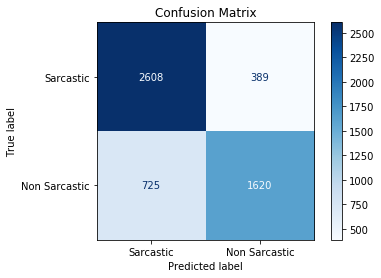

In [409]:
# Model Evaluation metrics 
print(f'Accuracy Score : {str(accuracy_score(y_test,y_pred))}  ')
print(f'Precision Score : {str(precision_score(y_test,y_pred))} ') 
print(f'Recall Score : {str(recall_score(y_test,y_pred))} ') 
print(f'F1 Score : {str(f1_score(y_test,y_pred))} ') 

disp = plot_confusion_matrix(svc, X_test, y_test, display_labels=['Sarcastic', 'Non Sarcastic'],
                             cmap=plt.cm.Blues, values_format= 'd');
disp.ax_.set_title('Confusion Matrix');

There is 79% Precision and 68% recall.
Precision means the percentage of results which are relevant. Recall refers to the percentage of total relevant results correctly classified by algorithm.

The score which consolidated both of them is F1, in this case of value 73.5% what is reasonably high.

In [410]:
badly_classified = df_test[ y_pred != y_test ] 

In [411]:
print("Some wrongly predicted headlines")
for i in range(5):
    print(f"\'{badly_classified.iloc[i]['headline']}\', real class: {badly_classified.iloc[i]['is_sarcastic']}")

Some wrongly predicted headlines
'israeli soldiers open fire on palestinians carrying potentially dangerous injured friends', real class: 1
'learned sage points out that powerball not as much after taxes', real class: 1
'americans finally found something to drink that's better than soda', real class: 0
'letter from employer thankfully omits balls-copying incident', real class: 1
'the louvre gardens are teeming with rats', real class: 0


With sarcasm there is this problem, that the words by itself does not create it. It is all about context, and with simple tf-idf the context is not taken into consideration during modeling